In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from neighborhoods import nearest_neighborhood
from datetime import date
from dateutil.relativedelta import relativedelta



In [2]:
df = pd.read_csv('eviction_notices.csv', parse_dates=['File Date'], encoding = "ISO-8859-1")

/Users/jakram/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
len(df)

37736

In [4]:
df.head()

,Eviction ID,Address,City,State,Eviction Notice Source Zipcode,File Date,Non Payment,Breach,Nuisance,Illegal Use,...,Roommate Same Unit,Other Cause,Late Payments,Lead Remediation,Development,Good Samaritan Ends,Constraints Date,Supervisor District,Neighborhoods - Analysis Boundaries,Location
0,M161957,300 Block Of Park Street,San Francisco,CA,94110,2016-06-06,False,False,False,False,...,False,False,False,False,False,False,NaN,9.0,Bernal Heights,"(37.7364374645373, -122.417989910582)"
1,M162256,200 Block Of Seneca Avenue,San Francisco,CA,94112,2016-06-29,False,False,False,False,...,False,False,False,False,False,False,8/25/2021,11.0,Outer Mission,"(37.7205429316262, -122.443264852669)"
2,M162135,200 Block Of Dolores Street,San Francisco,CA,94103,2016-06-28,False,True,False,False,...,False,False,False,False,False,False,NaN,8.0,Castro/Upper Market,"(37.7652067507312, -122.426591617441)"
3,M161901,1200 Block Of 9th Avenue,San Francisco,CA,94122,2016-06-02,False,False,False,False,...,False,False,False,False,False,False,NaN,5.0,Inner Sunset,"(37.764977785911, -122.4664456379)"
4,M162428,1400 Block Of Larkin Street,San Francisco,CA,94109,2016-02-28,False,False,False,False,...,False,False,False,False,False,False,NaN,3.0,Nob Hill,"(37.7912373166567, -122.419197310472)"


In [5]:
df = df.dropna(subset=['Location'])
len(df)

36289

In [6]:
mindate = date(2007, 9, 15) # This is the minimum date for which we have home values from Zillow.
df = df[df['File Date'] > mindate]
len(df)


15888

In [7]:
# Function appends data from Zillow API and data file using neighborhood()  
def addPricingData_lookback(row, lookback):
    latlng = row['Location']
    lat, lng = latlng.split(',')
    lat = float(lat.replace('(','')) # Reformat lat, lng to separate arguments.
    lng = float(lng.replace(')',''))
    evictdate = row['File Date'].date() # Convert eviction date and create date keys for eviciton date and starting valuation date. 
    startdate = evictdate + relativedelta(months=-lookback)
    evictdate_key = date.strftime(evictdate,"%b%Y")
    evictdateyear = date.strftime(evictdate,"%Y")
    startdate_key = date.strftime(startdate, "%b%Y")
    neighborhood = nearest_neighborhood(lat, lng) # Create neighborhood object for lat, lng.
    name = neighborhood.name
    meanvalue = float(neighborhood.meanvalue)
    evictdatevalue = neighborhood.prices[evictdate_key]
    s = neighborhood.prices[startdate_key]
    c = neighborhood.prices[evictdate_key]
    valueincrease = (c - s)/s
    return pd.Series({'Eviction_id':row['Eviction ID'],'Lat': lat, 'Lng': lng, 'Year': evictdateyear, 'Zillow_Neighborhood':name, 'Z_2017_Value':meanvalue, 'Z_Evict_Date_Value':evictdatevalue, 'Z_Value_Increase':valueincrease}) 
    return name

def addPricingData(row):
    latlng = row['Location']
    lat, lng = latlng.split(',')
    lat = float(lat.replace('(','')) # Reformat lat, lng to separate arguments.
    lng = float(lng.replace(')',''))
    evictdate = row['File Date'].date() # Convert eviction date and create date keys for eviciton date and starting valuation date. 
    evictdate_key = date.strftime(evictdate,"%b%Y")
    evictdateyear = date.strftime(evictdate,"%Y")
    neighborhood = nearest_neighborhood(lat, lng) # Create neighborhood object for lat, lng.
    name = neighborhood.name
    meanvalue = float(neighborhood.meanvalue)
    evictdatevalue = neighborhood.prices[evictdate_key]
    return pd.Series({'Eviction_id':row['Eviction ID'],'Lat': lat, 'Lng': lng, 'Year': evictdateyear, 'Zillow_Neighborhood':name, 'Z_2017_Value':meanvalue, 'Z_Evict_Date_Value':evictdatevalue}) 
    return name



In [9]:
aggregation_lookback = {
    'Owner Move In' : {
        'total_move_in' : 'sum'
    },
    'Condo Conversion' : {
         'total_condo' : 'sum'
    },
    'Ellis Act WithDrawal' : {
         'total_ellis' : 'sum'
    },
    'Eviction ID' : {
        'total_evictions' : 'count'
    },
    'Z_Value_Increase' : {
        'average_value_increase' : 'mean'
    },
    'Z_2017_Value' : {
        'current_value' : 'mean'
    },
    'Z_Evict_Date_Value' :{ 
        'eviction_date_value' : 'mean'
    }
}

lookbackperiod_mos = 18 # This is the number of lookback months to find change in home values prior to an eviction
lookbackdf = df[df['File Date'] > (mindate + relativedelta(months=+lookbackperiod_mos)) ]

# Merge the results of our calls to neighborhood() back to our dataframe.
lookbackdf = lookbackdf.merge(lookbackdf.apply(lambda row: addPricingData_lookback(row, lookbackperiod_mos), axis = 1), left_on='Eviction ID', right_on='Eviction_id')

# Creating a dataframe to group by neighborhood. 
groupby_hood = lookbackdf.groupby(['Zillow_Neighborhood']).agg(aggregation_lookback).reset_index()

# Adding columns to indicate frequency of certain eviction types.
groupby_hood['pct_move_in'] = groupby_hood[('Owner Move In','total_move_in')]/groupby_hood[('Eviction ID', 'total_evictions')]
groupby_hood['pct_condo'] = groupby_hood[('Condo Conversion','total_condo')]/groupby_hood[('Eviction ID', 'total_evictions')]
groupby_hood['pct_ellis'] = groupby_hood[('Ellis Act WithDrawal','total_ellis')]/groupby_hood[('Eviction ID', 'total_evictions')]
groupby_hood['pct_suspect'] = (groupby_hood[('Owner Move In','total_move_in')] + groupby_hood[('Ellis Act WithDrawal','total_ellis')] + groupby_hood[('Condo Conversion','total_condo')] 
                         )/groupby_hood[('Eviction ID', 'total_evictions')]

# Drop neighborhoods that lack Zillow pricing data.
groupby_hood = groupby_hood.dropna(subset=[('Z_Value_Increase', 'average_value_increase')]).reset_index()
# Drop neighborhoods with small sample sizes.
groupby_hood = groupby_hood[groupby_hood[('Eviction ID', 'total_evictions')] > 40]
# Print data frame. 
groupby_hood


,index,Zillow_Neighborhood,Owner Move In,Condo Conversion,Ellis Act WithDrawal,Eviction ID,Z_Value_Increase,Z_2017_Value,Z_Evict_Date_Value,pct_move_in,pct_condo,pct_ellis,pct_suspect
,,,total_move_in,total_condo,total_ellis,total_evictions,average_value_increase,current_value,eviction_date_value,,,,
0,3,Bayview,35.0,0.0,6.0,302,0.224686,612400.0,6.195523e+05,0.115894,0.000000,0.019868,0.135762
1,4,Bernal Heights,103.0,7.0,67.0,464,0.127983,1083700.0,9.645711e+05,0.221983,0.015086,0.144397,0.381466
2,5,Buena Vista Park,15.0,0.0,14.0,115,0.103227,1304100.0,1.138866e+06,0.130435,0.000000,0.121739,0.252174
3,6,Central Richmond,70.0,2.0,32.0,284,0.133190,1284800.0,1.158423e+06,0.246479,0.007042,0.112676,0.366197
4,7,Central Sunset,78.0,0.0,23.0,220,0.117563,994300.0,9.658918e+05,0.354545,0.000000,0.104545,0.459091
6,11,Corona Heights,18.0,0.0,4.0,70,0.112847,1325400.0,1.126299e+06,0.257143,0.000000,0.057143,0.314286
7,12,Cow Hollow,36.0,5.0,15.0,197,0.082179,1732300.0,1.514629e+06,0.182741,0.025381,0.076142,0.284264
8,13,Crocker Amazon,48.0,0.0,4.0,208,0.164779,724200.0,7.059921e+05,0.230769,0.000000,0.019231,0.250000
10,15,Downtown,4.0,0.0,7.0,403,0.110481,694600.0,6.208382e+05,0.009926,0.000000,0.017370,0.027295


In [10]:
pricingdf = df.merge(df.apply(addPricingData, axis=1), left_on='Eviction ID', right_on='Eviction_id')
pricingdf

,Eviction ID,Address,City,State,Eviction Notice Source Zipcode,File Date,Non Payment,Breach,Nuisance,Illegal Use,...,Supervisor District,Neighborhoods - Analysis Boundaries,Location,Eviction_id,Lat,Lng,Year,Z_2017_Value,Z_Evict_Date_Value,Zillow_Neighborhood
0,M161957,300 Block Of Park Street,San Francisco,CA,94110,2016-06-06,False,False,False,False,...,9.0,Bernal Heights,"(37.7364374645373, -122.417989910582)",M161957,37.736437,-122.417990,2016,1083700.0,1193000.0,Bernal Heights
1,M162256,200 Block Of Seneca Avenue,San Francisco,CA,94112,2016-06-29,False,False,False,False,...,11.0,Outer Mission,"(37.7205429316262, -122.443264852669)",M162256,37.720543,-122.443265,2016,814200.0,951300.0,Mission Terrace
2,M162135,200 Block Of Dolores Street,San Francisco,CA,94103,2016-06-28,False,True,False,False,...,8.0,Castro/Upper Market,"(37.7652067507312, -122.426591617441)",M162135,37.765207,-122.426592,2016,0.0,NaN,Duboce Triangle
3,M161901,1200 Block Of 9th Avenue,San Francisco,CA,94122,2016-06-02,False,False,False,False,...,5.0,Inner Sunset,"(37.764977785911, -122.4664456379)",M161901,37.764978,-122.466446,2016,1154400.0,1362400.0,Inner Sunset
4,M162428,1400 Block Of Larkin Street,San Francisco,CA,94109,2016-02-28,False,False,False,False,...,3.0,Nob Hill,"(37.7912373166567, -122.419197310472)",M162428,37.791237,-122.419197,2016,1192900.0,1461900.0,Nob Hill
5,M161943,300 Block Of Wilde Avenue,San Francisco,CA,94134,2016-06-06,False,False,True,False,...,10.0,Visitacion Valley,"(37.7167969475402, -122.403664398767)",M161943,37.716797,-122.403664,2016,689000.0,743500.0,Little Hollywood
6,M161986,0 Block Of Fair Avenue,San Francisco,CA,94110,2016-06-13,False,True,False,False,...,9.0,Bernal Heights,"(37.7453025419492, -122.419008184627)",M161986,37.745303,-122.419008,2016,1083700.0,1193000.0,Bernal Heights
7,M161976,1300 Block Of Market Street,San Francisco,CA,94102,2016-06-13,True,False,False,False,...,6.0,Tenderloin,"(37.777083463941, -122.416979326588)",M161976,37.777083,-122.416979,2016,713000.0,812300.0,Van Ness - Civic Center
8,M162257,300 Block Of Lombard Street,San Francisco,CA,94133,2016-06-30,False,False,False,False,...,3.0,North Beach,"(37.8035109665788, -122.407095028398)",M162257,37.803511,-122.407095,2016,852000.0,952100.0,North Waterfront
9,M161838,2800 Block Of Pierce Street,San Francisco,CA,94123,2016-06-01,False,False,False,False,...,2.0,Marina,"(37.7961971224445, -122.438753767562)",M161838,37.796197,-122.438754,2016,1732300.0,2104800.0,Cow Hollow


In [14]:
aggregation_pricing = {
    'Owner Move In' : {
        'total_move_in' : 'sum'
    },
    'Condo Conversion' : {
         'total_condo' : 'sum'
    },
    'Ellis Act WithDrawal' : {
         'total_ellis' : 'sum'
    },
    'Eviction ID' : {
        'total_evictions' : 'count'
    },
    'Z_2017_Value' : {
        'current_value' : 'mean'
    },
    'Z_Evict_Date_Value' :{ 
        'eviction_date_value' : 'mean'
    }
}

# Creating a dataframe to group by year, then neighborhood. 
groupby_year_hood = pricingdf.groupby(['Zillow_Neighborhood', 'Year']).agg(aggregation_pricing).reset_index()
# Drop neighborhoods that lack Zillow pricing data.
groupby_year_hood = groupby_year_hood.dropna(subset=[('Z_2017_Value', 'current_value')]).reset_index()
groupby_year_hood

,index,Zillow_Neighborhood,Year,Owner Move In,Condo Conversion,Ellis Act WithDrawal,Eviction ID,Z_2017_Value,Z_Evict_Date_Value
,,,,total_move_in,total_condo,total_ellis,total_evictions,current_value,eviction_date_value
0,0,Alamo Square,2007,1.0,0.0,10.0,31,0.0,NaN
1,1,Alamo Square,2008,3.0,0.0,1.0,43,0.0,NaN
2,2,Alamo Square,2009,3.0,0.0,1.0,23,0.0,NaN
3,3,Alamo Square,2010,1.0,0.0,0.0,19,0.0,NaN
4,4,Alamo Square,2011,3.0,0.0,0.0,19,0.0,NaN
5,5,Alamo Square,2012,4.0,0.0,0.0,18,0.0,NaN
6,6,Alamo Square,2013,2.0,0.0,0.0,19,0.0,NaN
7,7,Alamo Square,2014,2.0,1.0,0.0,24,0.0,NaN
8,8,Alamo Square,2015,4.0,0.0,0.0,26,0.0,NaN


In [20]:
aggregation_pricing = {
    'Owner Move In' : {
        'total_move_in' : 'sum'
    },
    'Condo Conversion' : {
         'total_condo' : 'sum'
    },
    'Ellis Act WithDrawal' : {
         'total_ellis' : 'sum'
    },
    'Eviction ID' : {
        'total_evictions' : 'count'
    },
    'Z_2017_Value' : {
        'current_value' : 'mean'
    },
    'Z_Evict_Date_Value' :{ 
        'eviction_date_value' : 'mean'
    }
}

# Creating a dataframe to group by year, then neighborhood. 
groupby_year = pricingdf.groupby(['Year']).agg(aggregation_pricing).reset_index()
# Drop neighborhoods that lack Zillow pricing data.
groupby_year = groupby_year.dropna(subset=[('Z_2017_Value', 'current_value')]).reset_index()
groupby_year

,index,Year,Owner Move In,Condo Conversion,Ellis Act WithDrawal,Eviction ID,Z_2017_Value,Z_Evict_Date_Value
,,,total_move_in,total_condo,total_ellis,total_evictions,current_value,eviction_date_value
0,0,2007,43.0,0.0,86.0,457,9.273363e+05,8.870012e+05
1,1,2008,165.0,2.0,192.0,1385,1.004217e+06,8.784128e+05
2,2,2009,113.0,2.0,48.0,1146,9.362609e+05,7.278245e+05
3,3,2010,117.0,4.0,68.0,1322,7.755082e+05,7.656215e+05
4,4,2011,124.0,2.0,54.0,1265,8.841570e+05,7.682928e+05
5,5,2012,171.0,11.0,99.0,1601,8.469024e+05,8.031838e+05
6,6,2013,272.0,11.0,231.0,1823,9.036601e+05,9.321901e+05
7,7,2014,311.0,10.0,100.0,1914,9.617534e+05,1.113736e+06
8,8,2015,419.0,18.0,146.0,2052,9.911032e+05,1.258890e+06


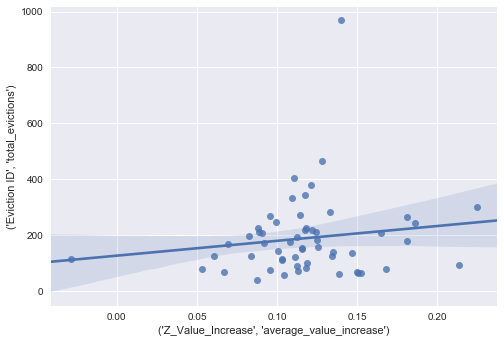

In [21]:
ax = sns.regplot(y=groupby_hood[('Eviction ID', 'total_evictions')], x=groupby_hood[('Z_Value_Increase', 'average_value_increase')], data=groupby_hood)
plt.show()

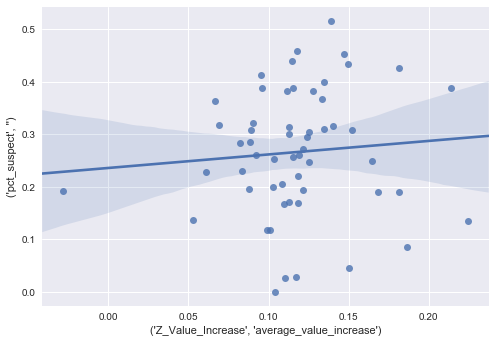

In [22]:
ax = sns.regplot(y=groupby_hood[('pct_suspect', '')], x=groupby_hood[('Z_Value_Increase', 'average_value_increase')], data=groupby_hood)
plt.show()

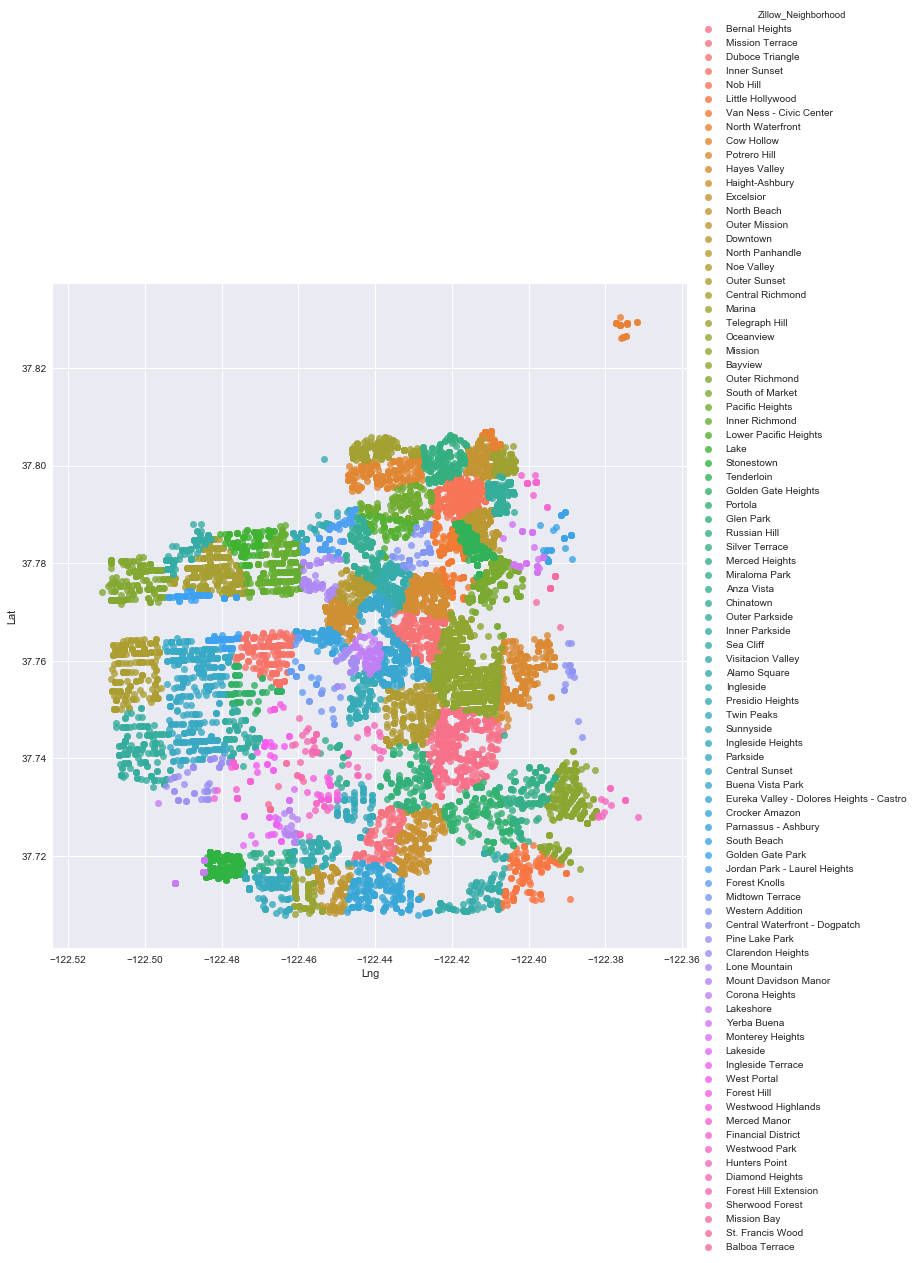

In [24]:
ax = sns.lmplot(x='Lng', y='Lat', hue='Zillow_Neighborhood', size=10, data=pricingdf, fit_reg=False, legend_out=True)
# ax.set_xlim(-122.55,-122.35)
# ax.set_ylim(37.7,37.81)
plt.show()

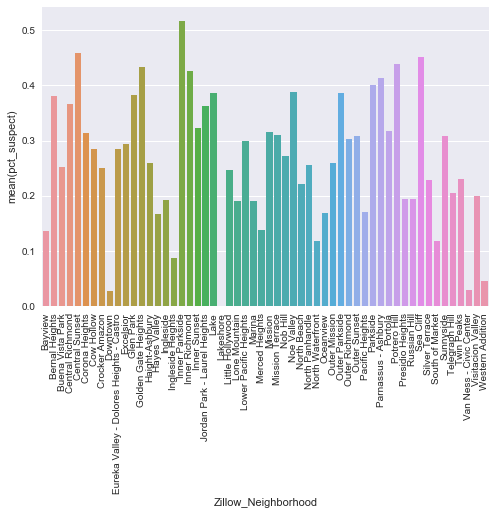

In [25]:
ax = sns.barplot(x='Zillow_Neighborhood', y='pct_suspect', data=groupby_hood)
ax.set_xticklabels(labels=groupby_hood['Zillow_Neighborhood'], rotation=90)
plt.show()